In [484]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
# import numba
from numba import njit
import plotly.graph_objects as go

In [485]:
savedir = "./"
L = 16
binsize = L//2
correlated = True

kappa = 0.0
kbt = 1e-7
u0 = 0
cs2 = 1/3
gamma = 5.0
chi = 0.5
T = 0.4
rho0 = 1.0
phi0 = 0.0

slc = np.s_[L//2, L//2, L//2]

# Helper functions

In [486]:
def lattice_fourier_laplacian(kx, ky, kz):
    expr1 = np.cos(kx) + np.cos(ky) + np.cos(kz)
    expr2 = np.cos(kx)*np.cos(ky) + np.cos(ky)*np.cos(kz) + np.cos(kx)*np.cos(kz)
    out = 2/9*expr1 + 2/9*expr2 - 4/3
    return -out/cs2

def model_cs2(density, C0):
    return T

def cs2k(kx, ky, kz, density, C0):
    thermal_cs2 = model_cs2(density, C0)
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    if correlated:
        out = thermal_cs2 + 2*k2*kappa*(density - C0)
    else:
        out = thermal_cs2
    return out

# def mu_c(density, C0):
#     # return (-T*density*np.log((density - C0)/C0) - Lambda*(2.*C0 - density))/(2.*density)
#     return (-C0*chi*(C0 - density) - T*np.power(density, 2)/2)/(C0*density*(C0 - density))

def mu_c(rho0, phi0):
    return (-2.*T*np.power(rho0, 2) - chi*np.power(phi0, 2) + chi*np.power(rho0, 2))/(2.*rho0*(np.power(phi0, 2) - np.power(rho0, 2)))

def mu_ck(kx, ky, kz, density, C0):
    ref_state = mu_c(density, C0)
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    if correlated:
        out = ref_state + 4*kappa*k2*C0
    else:
        out = ref_state
    return out

In [487]:
def spherically_averaged_structure_factor(data, density, C0, scale_factor = 1, func = None, shift = True, cs = True):
    L = min(data.shape)
    S = data.copy()

    if shift:
        freqs = fft.fftshift(fft.fftfreq(L))
    else:
        freqs = fft.fftfreq(L)
    if len(data.shape) == 3:
        kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
        k = np.stack([kx, ky, kz], axis = -1)
    elif len(data.shape) == 2:
        kx, ky = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L]]), indexing='ij')
        k = np.stack([kx, ky], axis = -1)
     
    k1 = np.linalg.norm(k, axis=-1).flatten()
    
    if func is not None:
        if cs:
            S = func(S, cs2k(kx, ky, kz, density, C0))
        else:
            S = func(S, mu_ck(kx, ky, kz, density, C0))
    S /= scale_factor

    S1 = S.flatten()
    kmin = 2*np.pi/L # sampling frequency
    where = np.s_[:]#np.where(k1<=kmax)
    bins = np.arange(L//2+1)*kmin # kmax+1 for bin_edges: len(bins)=len(hist)+1
    
    shells = np.histogram(k1[where], bins, weights=S1[where])[0]
    counts = np.histogram(k1[where], bins)[0]
    return (bins[:-1]+bins[1:])/2, shells/counts

In [488]:
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return r, azimuth, elevation

def sph2cart(azimuth,elevation,r):
    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def radial_equilibration(data, density, C0, radius = 1, scale_factor = 1, func = None, cs = True):
    S = data.copy()
    L = min(S.shape)
    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')

    r, t, p = cart2sph(kx, ky, kz)

    if func is not None:
        if cs:
            S = func(S, cs2k(kx, ky, kz, density, C0))
        else:
            S = func(S, mu_ck(kx, ky, kz, density, C0))
    S /= scale_factor

    idxs = np.isclose(r, radius, atol = 2*np.pi/L)
    t = t[idxs]
    p = p[idxs]
    out = S[idxs]

    return t, p, out

In [489]:
def make_bins(to_bin1, binsize, to_bin2 = None):
    bins = np.linspace(to_bin1.min(), to_bin1.max(), binsize)

    out1 = np.zeros(binsize)
    shell = np.digitize(to_bin1, bins = bins, right = True)
    np.add.at(out1, shell, to_bin1)
    unique, counts = np.unique(shell, return_counts=True)
    out1 = out1[unique]
    out1 /= counts

    if to_bin2 is None:
        return bins, out1
    else:
        out2 = np.zeros(binsize)
        np.add.at(out2, shell, to_bin2)
        unique, counts = np.unique(shell, return_counts=True)
        out2 = out2[unique]
        out2 /= counts
        return out1, out2

# Validation

## Equilibration ratios

In [490]:
idx = -1
rho_data = 1.0
C1_data = 0.0
ts = yt.load(savedir+"SF_plt_mag*")
ds = ts[idx]
ad = ds.all_data()

yt : [INFO     ] 2024-08-11 23:05:08,854 Parameters: current_time              = 2000.0
yt : [INFO     ] 2024-08-11 23:05:08,856 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-08-11 23:05:08,857 Parameters: domain_left_edge          = [-50.26548246 -50.26548246 -50.26548246]
yt : [INFO     ] 2024-08-11 23:05:08,858 Parameters: domain_right_edge         = [50.26548246 50.26548246 50.26548246]


In [491]:
ds.field_list

[('boxlib', 'struct_fact_density_density'),
 ('boxlib', 'struct_fact_density_phi'),
 ('boxlib', 'struct_fact_density_ux'),
 ('boxlib', 'struct_fact_density_uy'),
 ('boxlib', 'struct_fact_density_uz'),
 ('boxlib', 'struct_fact_phi_phi'),
 ('boxlib', 'struct_fact_phi_ux'),
 ('boxlib', 'struct_fact_phi_uy'),
 ('boxlib', 'struct_fact_phi_uz'),
 ('boxlib', 'struct_fact_ux_ux'),
 ('boxlib', 'struct_fact_ux_uy'),
 ('boxlib', 'struct_fact_ux_uz'),
 ('boxlib', 'struct_fact_uy_uy'),
 ('boxlib', 'struct_fact_uy_uz'),
 ('boxlib', 'struct_fact_uz_uz')]

### Density

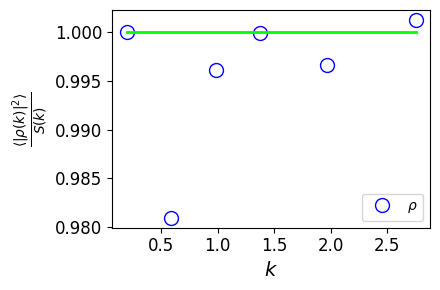

In [492]:
data = [np.array(ad[('boxlib', 'struct_fact_density_density')]).reshape(L, L, L)]
slc = np.s_[L//2, L//2, L//2]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\rho$"]

rho_scale = lambda a, c: a*c
scale_factor = 1
# scale_factor = cs2

for d in data:
        d[slc] *= kbt/(L**3*T)
        x, y = spherically_averaged_structure_factor(d, rho_data, C1_data, scale_factor = scale_factor, func = rho_scale)
        x, y = make_bins(x, binsize, to_bin2 = y)
        ax.plot(x, y, 
                marker = markers[0], color = colors[0],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
# ax.set_ylim([0.9, 1.1])
fig.tight_layout()
# fig.savefig("./equilibration_ratio.svg")

In [493]:
print(np.mean(y[1:]))

0.9949437852063753


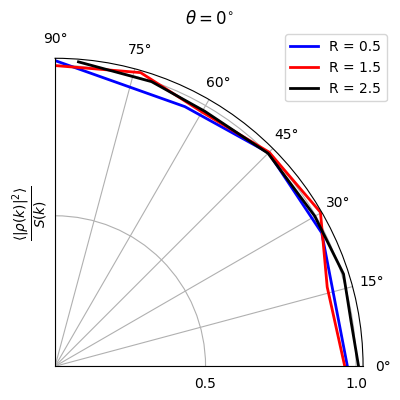

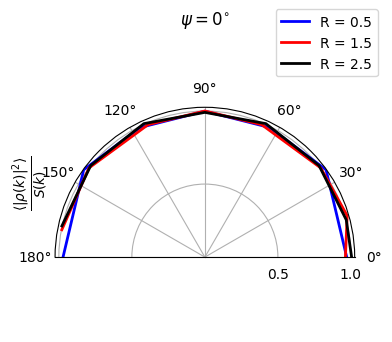

In [494]:
sz = 4
fig, tax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1.5, 2.5]

t_angle = 0
p_angle = 0 
# binsize = 10

# rho_scale = None
# scale_factor = 1/cs2

for d in data:
    ax1 = tax
    ax2 = pax
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho_data, C1_data, radius = r, func=rho_scale, scale_factor = scale_factor)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)


    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

fig.tight_layout()

### C1

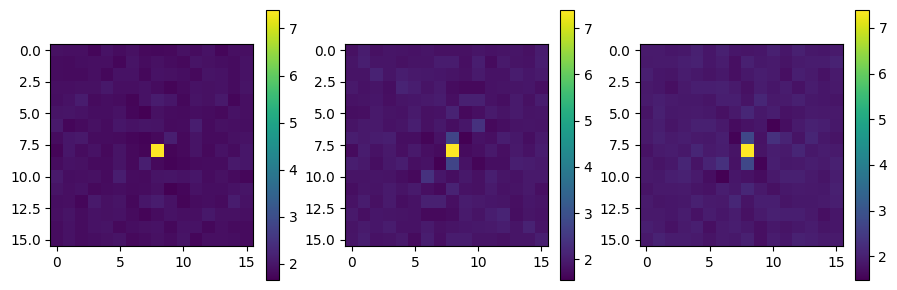

In [510]:
freqs = fft.fftshift(fft.fftfreq(L))
kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
k2 = lattice_fourier_laplacian(kx, ky, kz)
experiment_muck = mu_ck(kx, ky, kz, 1.0, 0.5)
data = [np.array(ad[('boxlib', 'struct_fact_phi_phi')]).reshape(L, L, L)]

test = data[0].copy()
# test[slc] *= 3*T

fig, axs = plt.subplots(1, 3, figsize = (9, 3))

ax = axs[0]
test *= (experiment_muck)
im = ax.imshow(test[L//2, :, :])
plt.colorbar(im, ax = ax)

ax = axs[1]
im = ax.imshow(test[:, L//2, :])
plt.colorbar(im, ax = ax)

ax = axs[2]
im = ax.imshow(test[:, :, L//2])
plt.colorbar(im, ax = ax)

fig.tight_layout()

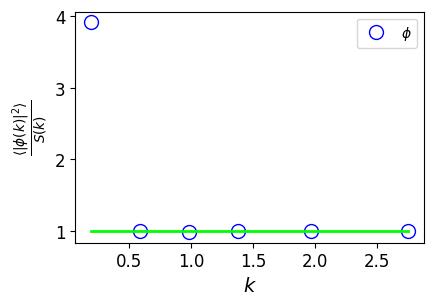

In [512]:
data = [np.array(ad[('boxlib', 'struct_fact_phi_phi')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\phi$"]

rho_func = lambda a, c: a*c
scale_factor = 1

for d in data:
        # d[slc] *= 3*T
        # print(d[slc])
        x, y = spherically_averaged_structure_factor(d, rho_data, C1_data, scale_factor = scale_factor, func = rho_func, cs = False)
        x, y = make_bins(x, binsize, to_bin2 = y)
        ax.plot(x, y, 
                marker = markers[0], color = colors[0],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \phi(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
# print(x, y)
# ax.set_ylim([0.95, 1.05])

In [508]:
y

array([3.91364328, 1.00307578, 0.98015393, 1.00042043, 1.00155737,
       0.99992562])

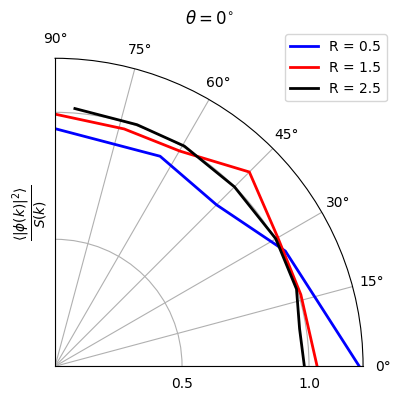

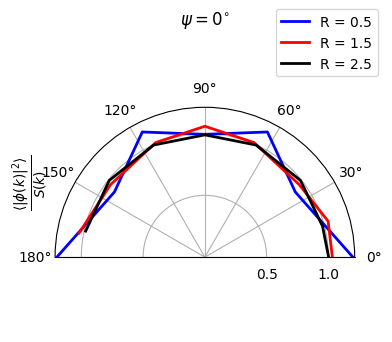

In [497]:
sz = 4
fig, tax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1.5, 2.5]

t_angle = 0
p_angle = 0 
# binsize = 10

# rho_scale = None
# scale_factor = 1/cs2

for d in data:
    ax1 = tax
    ax2 = pax
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho_data, C1_data, radius = r, func=rho_scale, scale_factor = scale_factor, cs = False)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)


    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | \phi(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | \phi(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

fig.tight_layout()

### Velocities

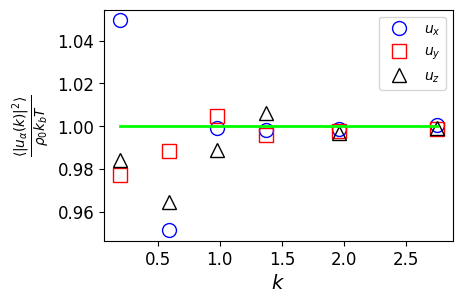

In [498]:
data = [np.array(ad[('boxlib', 'struct_fact_ux_ux')]).reshape(L, L, L), 
        np.array(ad[('boxlib', 'struct_fact_uy_uy')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_uz_uz')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$u_x$", r"$u_y$", r"$u_z$"]

for i, d in enumerate(data):
        d[slc] *= T/kbt
        x, y = spherically_averaged_structure_factor(d, rho_data, C1_data, scale_factor = 1)
        x, y = make_bins(x, binsize, to_bin2 = y)

        ax.plot(x, y, 
                marker = markers[i], color = colors[i],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[i])
ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | u_{\alpha}(k) | ^2 \rangle }{\rho_{0}k_b T}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
# ax.set_ylim([0.9, 1.1])

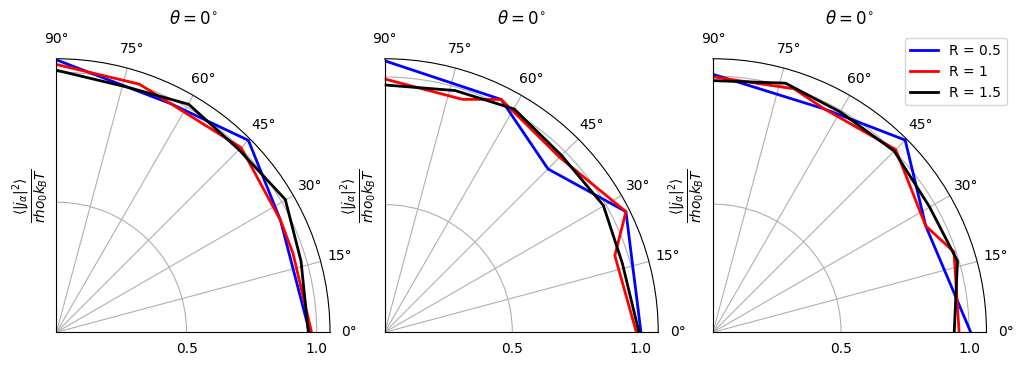

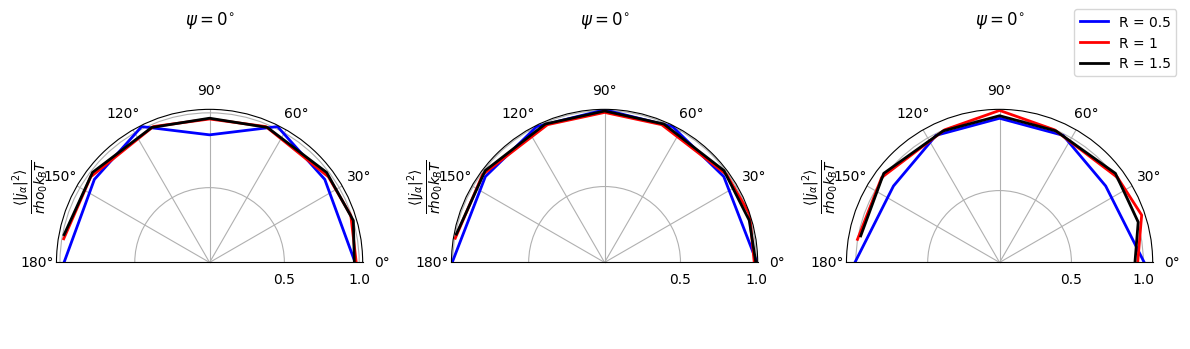

In [499]:
sz = 4
fig, tax = plt.subplots(1, 3, figsize = (sz*3, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 3, figsize = (sz*3, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1, 1.5]

t_angle = 0
p_angle = 0 
# binsize = 10

for j, d in enumerate(data):
    ax1 = tax[j]
    ax2 = pax[j]
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho_data, C1_data, radius = r)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | j_{\alpha} | ^2 \rangle }{rho_0 k_B T}$", fontsize = 14)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | j_{\alpha} | ^2 \rangle }{rho_0 k_B T}$", fontsize = 14)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)

fig.tight_layout()

# Valid variable range

From the covariance matrix, certain limits on parameter values are set based upon ensuring that the diagonal remains positive. This limit is set by the term. $5 - c_s^2(k)$ in Xi[5, 5] which corresponds to a maximum allowable $c_s^2(k) = 0.\bar{5}$. The parameter that controls $c_s^2$ is $T$ as $c_s^2 = T$. $T_c$ or the critical temperature where demixing begins is defined as $T_c = \lambda/2$. In the expression for calculating $c_s^2(k) = c_s^2 + \kappa \rho_0 k^2$, $\kappa$ also controls the value of $c_s^2(k)$. Therefore this phase diagram will be defined using $\lambda$ and $\kappa$. Tested ranges will be $0.1 \leq \lambda \leq 1.1$ and $0.01 \leq \kappa \leq 0.05$

#### Helper functions

In [500]:
@njit()
def lattice_fourier_laplacian(kx, ky, kz):
    expr1 = np.cos(kx) + np.cos(ky) + np.cos(kz)
    expr2 = np.cos(kx)*np.cos(ky) + np.cos(ky)*np.cos(kz) + np.cos(kx)*np.cos(kz)
    out = 2/9*expr1 + 2/9*expr2 - 4/3
    return -out/cs2

In [501]:
@njit()
def cholesky_decomp(arr_in, n, bstart):
    A = arr_in.copy()
    # sum = 0
    for i in range(bstart, n):
        for j in range(bstart, i + 1):
            sum = A[i*n + j]
            for k in range(j - 1, bstart - 1, -1):
                sum -= A[i*n+k]*A[j*n+k]
            if i == j:
                if sum >= 0:
                    A[i*n+j] = np.sqrt(sum)
                else:
                    A[i*n+j] = 0
                    raise ValueError(f"Row {i} in matrix not spd!")
            else:
                if A[j*n+j] > 0:
                    A[i*n+j] = sum/A[j*n+j]
                else:
                    raise ValueError("Matrix diagonal is 0")

    for i in range(0, n):
        for j in range(i + 1, n):
            A[i*n+j] = 0

    return A

In [502]:
@njit()
def covariance_matrix(k2, chi, T, kappa):
    rho0 = 1.0
    C0 = 0.5
    kT = 1e-7
    tau_r = 0.788675
    tau_p = 1.0
    Gamma = 1.0

    lambda_r = 1./tau_r
    lambda_p = 1./tau_p
    cs2k = T + 2.*kappa*k2*(rho0-C0)  # checked after conversion
    mu_rho = -(T/(C0-rho0) + 2*chi*(C0**2)/(rho0 ** 3)) -2.*kappa*k2*rho0  # checked after conversion
    mu_C = ((-C0*chi*(C0-rho0) - T*(rho0**2)/2)/(C0*rho0*(C0-rho0)) + 4.*kappa*k2*C0)/2  # checked after conversion
    p_C = 4.*kappa*k2*C0 - 2.*kappa*k2*rho0  # checked after conversion

    Xi = np.zeros(38*38)
    # THESE ARE NOT DISCRETIZED IN TIME. THAT STEP IS IN THE THERMALIZE MOMENTS FUNCTION
    Xi[23] = -3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[35] = 3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[46] = -3*kT*lambda_r*(k2*kappa*(2*C0 - rho0) + p_C)/(mu_C*rho0);
    Xi[58] = 3*kT*lambda_r*(k2*kappa*(2*C0 - rho0) + p_C)/(mu_C*rho0);
    Xi[81] = kT*lambda_p*(-2*C0 + rho0);
    Xi[120] = kT*lambda_p*(-2*C0 + rho0);
    Xi[159] = kT*lambda_p*(-2*C0 + rho0);
    Xi[192] = kT*lambda_p*(-2*C0 + rho0);
    Xi[195] = 2*Gamma*kT*lambda_p/rho0;
    Xi[231] = kT*lambda_p*(-2*C0 + rho0);
    Xi[234] = 2*Gamma*kT*lambda_p/rho0;
    Xi[270] = kT*lambda_p*(-2*C0 + rho0);
    Xi[273] = 2*Gamma*kT*lambda_p/rho0;
    Xi[305] = -3*kT*lambda_r*(k2*kappa*(2*C0 - rho0) + p_C)/(mu_C*rho0);
    Xi[312] = 2*kT*lambda_r*rho0*(5 - 9*cs2k);
    Xi[324] = 6*kT*lambda_r*rho0*(3*cs2k - 1);
    Xi[327] = -3*kT*(Gamma*lambda_p*mu_C*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_C - 1)*(k2*kappa*(2*C0 - rho0) + p_C))/(cs2k*mu_C*rho0);
    Xi[339] = 3*kT*(Gamma*lambda_p*mu_C*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_C - 1)*(k2*kappa*(2*C0 - rho0) + p_C))/(cs2k*mu_C*rho0);
    Xi[351] = 8*kT*lambda_r*rho0;
    Xi[390] = (8.0/3.0)*kT*lambda_r*rho0;
    Xi[429] = (2.0/3.0)*kT*lambda_r*rho0;
    Xi[468] = (2.0/3.0)*kT*lambda_r*rho0;
    Xi[507] = (2.0/3.0)*kT*lambda_r*rho0;
    Xi[546] = 4*kT*lambda_r*rho0;
    Xi[585] = 4*kT*lambda_r*rho0;
    Xi[624] = 4*kT*lambda_r*rho0;
    Xi[663] = (4.0/3.0)*kT*lambda_r*rho0;
    Xi[702] = (4.0/3.0)*kT*lambda_r*rho0;
    Xi[741] = (4.0/3.0)*kT*lambda_r*rho0;
    Xi[761] = 3*kT*lambda_r*(k2*kappa*(2*C0 - rho0) + p_C)/(mu_C*rho0);
    Xi[768] = 6*kT*lambda_r*rho0*(3*cs2k - 1);
    Xi[780] = 18*kT*lambda_r*rho0*(1 - cs2k);
    Xi[783] = 3*kT*(Gamma*lambda_p*mu_C*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_C - 1)*(k2*kappa*(2*C0 - rho0) + p_C))/(cs2k*mu_C*rho0);
    Xi[795] = -3*kT*(Gamma*lambda_p*mu_C*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_C - 1)*(k2*kappa*(2*C0 - rho0) + p_C))/(cs2k*mu_C*rho0);
    Xi[819] = 8*kT*lambda_r*rho0;
    Xi[858] = (8.0/3.0)*kT*lambda_r*rho0;
    Xi[874] = -3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[882] = -3*kT*(Gamma*lambda_p*mu_C*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_C - 1)*(k2*kappa*(2*C0 - rho0) + p_C))/(cs2k*mu_C*rho0);
    Xi[894] = 3*kT*(Gamma*lambda_p*mu_C*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_C - 1)*(k2*kappa*(2*C0 - rho0) + p_C))/(cs2k*mu_C*rho0);
    Xi[897] = 2*Gamma*kT*lambda_p*(-9*Gamma*mu_C + 5)/rho0;
    Xi[909] = 6*Gamma*kT*lambda_p*(3*Gamma*mu_C - 1)/rho0;
    Xi[936] = 8*Gamma*kT*lambda_p/rho0;
    Xi[975] = (8.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1014] = (2.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1053] = (2.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1092] = (2.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1131] = 4*Gamma*kT*lambda_p/rho0;
    Xi[1170] = 4*Gamma*kT*lambda_p/rho0;
    Xi[1209] = 4*Gamma*kT*lambda_p/rho0;
    Xi[1248] = (4.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1287] = (4.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1326] = (4.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1330] = 3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[1338] = 3*kT*(Gamma*lambda_p*mu_C*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_C - 1)*(k2*kappa*(2*C0 - rho0) + p_C))/(cs2k*mu_C*rho0);
    Xi[1350] = -3*kT*(Gamma*lambda_p*mu_C*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_C - 1)*(k2*kappa*(2*C0 - rho0) + p_C))/(cs2k*mu_C*rho0);
    Xi[1353] = 6*Gamma*kT*lambda_p*(3*Gamma*mu_C - 1)/rho0;
    Xi[1365] = 18*Gamma*kT*lambda_p*(-Gamma*mu_C + 1)/rho0;
    Xi[1404] = 8*Gamma*kT*lambda_p/rho0;
    Xi[1443] = (8.0/3.0)*Gamma*kT*lambda_p/rho0;
    return Xi

#### Plotting

In [503]:
@njit()
def output_spd(k2, CHI, KAPPA, T_IN):
    SPD = np.zeros_like((CHI))

    for x in range(SPD.shape[0]):
        for y in range(SPD.shape[1]):
            for z in range(SPD.shape[2]):
                test_spd = True
                for kval in np.nditer(k2.T):
                    try:
                        Xi = covariance_matrix(kval, CHI[x,y,z], T_IN[x,y,z], KAPPA[x, y, z])
                        cholesky_decomp(Xi, 38, 5)
                    except:
                        test_spd = False
                        break 
                SPD[x, y, z] = test_spd
                
    return SPD

In [504]:
import os

if not os.path.exists("spd_covariance_matrix.npz"):
    chimin = 0.2
    chimax = 0.6

    kappamin = 0.0
    kappamax = 0.05

    propmin = 0.5
    propmax = 2

    points = 50

    chi_s = np.linspace(chimin, chimax, points)
    kappa_s = np.linspace(kappamin, kappamax, points)
    prop_s = np.linspace(propmin, propmax, points)

    CHI, KAPPA, PROP = np.meshgrid(*[chi_s, kappa_s, prop_s])
    T_IN = (CHI/2)*PROP

    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    
    SPD = output_spd(k2, CHI, KAPPA, T_IN)
    np.savez("spd_covariance_matrix.npz", chi = CHI, kappa = KAPPA, T = T_IN, SPD = SPD)

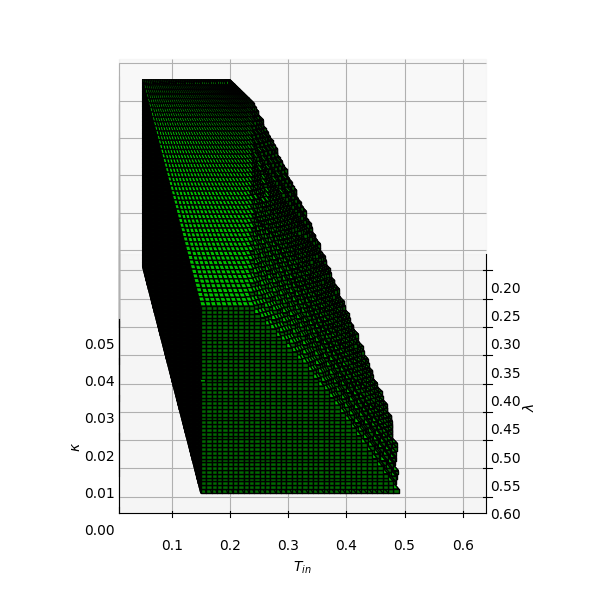

In [505]:
FILE_IN = np.load("spd_covariance_matrix.npz")
CHI = FILE_IN['chi']
KAPPA = FILE_IN['kappa']
T_IN = FILE_IN['T']
SPD = FILE_IN['SPD']

fig = plt.figure(figsize = (6, 6)) 
ax = fig.add_subplot(projection='3d')
ax.set_proj_type('ortho')
colors = np.empty(SPD.shape, dtype=object)
colors[SPD == 0] = "w"
colors[SPD == 1] = "lime"

out = ax.voxels(CHI, T_IN, KAPPA, SPD[:-1, :-1, :-1], facecolors=colors[:-1, :-1, :-1], edgecolor='k')
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$T_{in}$")
ax.set_zlabel(r"$\kappa$")
fig.tight_layout()

ax.view_init(45, 0, 0) # ax.view_init(elev, azim, roll)
# ax.view_init(90, 90, 0) # ax.view_init(elev, azim, roll)
fig.tight_layout()

In [506]:
# fig, ax = plt.subplots(1, 1, figsize = (3, 3))

# slc = 5
# # im = ax.contourf(CHI[..., slc], KAPPA[..., slc], SPD[..., slc], levels = 1, colors = ['tab:gray', 'w'])
# im = ax.contourf(CHI[slc], T[slc], SPD[slc], levels = 1, colors = ['tab:gray', 'w'])
# ax.set_xlabel(r"$\lambda$")
# ax.set_ylabel(r"$\kappa$")
# ax.set_title(f"$T = {chi_s[slc]:.3f}\lambda$")

# fig.tight_layout()